In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

import os
from scipy import stats
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from auditory_cortex.neural_data import NormalizerCalculator
from auditory_cortex.neural_data import create_neural_metadata
from auditory_cortex import results_dir
from auditory_cortex.plotters.plotter_utils import PlotterUtils

In [2]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

In [3]:
# read all the normalizer and null distributions
bin_width = 50
mVocs = False
p_value = 0.05
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
session_null_dist = {}
session_norm_dist = {}
for session in sessions:
    norm_dist, null_dist = norm_obj.get_inter_trial_corr_dists_for_session(
        session, bin_width=bin_width, mVocs=mVocs, force_redo=False
    )
     
    session_null_dist[session] = null_dist
    session_norm_dist[session] = norm_dist
 

INFO:Getting normalizer dist. for sess-180413, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180420, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180501, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180502, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180613, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180622, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180627, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180717, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180719, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180720, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180724, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180728, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180730, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180731, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-180807, bw-50, mVocs=False
INFO:Getti

### highly-tuned channels as a function of gap

In [4]:
# identify tuned neurons at different thresholds
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
std_deviations_away = np.linspace(0, 2.5, 26)
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
total_channels = 0

exact_gap_sess_channels = {gap: {} for gap in std_deviations_away}
for session in sessions:
    norm_dist = session_norm_dist[session]
    null_dist = session_null_dist[session]

    norm_means = np.array([np.mean(dist) for ch, dist in norm_dist.items()])
    null_means = np.array([np.mean(dist) for ch, dist in null_dist.items()])

    norm_medians = np.array([np.median(dist) for ch, dist in norm_dist.items()])
    null_medians = np.array([np.median(dist) for ch, dist in null_dist.items()])

    null_std = np.array([np.std(dist) for ch, dist in null_dist.items()])
    total_channels += len(null_std)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned[s] += len(highly_tuned)

        diff = np.abs(norm_means - thresh)
        highly_tuned = np.where(diff<0.01)[0]
        if len(highly_tuned) > 0:
            exact_gap_sess_channels[s][session] = highly_tuned
     
        thresh = null_medians + (s * null_std)
        highly_tuned = np.where(norm_medians > thresh)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)


print(f"Total channels: {total_channels}")

Total channels: 1718


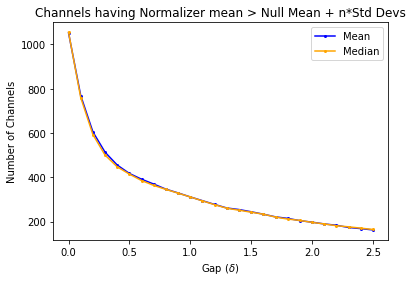

In [5]:
save_tikz=False
plt.plot(
    std_deviations_away, [total_highly_tuned[s] for s in std_deviations_away], marker='o', ms=2,
    color='blue', label='Mean'
    )
plt.plot(
    std_deviations_away, [total_highly_tuned_medians[s] for s in std_deviations_away], marker='o', ms=2,
    color='orange', label='Median'
    )
plt.xlabel('Gap ($\delta$)')
plt.ylabel('Number of Channels')
plt.title('Channels having Normalizer mean > Null Mean + n*Std Devs')
plt.legend()

stim = 'mVocs' if mVocs else 'timit'
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"highly-tuned-channels--bw-{bin_width}-{stim}.tex"
        )
    PlotterUtils.save_tikz(filepath)

### channels at exact gap

In [6]:
gaps = [0.1, 0.5, 1.0]
selected_sess_ch = {}
sess_ch_gaps = {}
for gap in gaps:
    rand_sess = np.random.choice(list(exact_gap_sess_channels[gap].keys()))
    rand_ch = np.random.choice(exact_gap_sess_channels[gap][rand_sess])

    if rand_sess in selected_sess_ch.keys():
        selected_sess_ch[rand_sess].append(rand_ch)
    else:
        selected_sess_ch[rand_sess] = [rand_ch]
    sess_ch_gaps[f"{rand_sess}-{rand_ch}"] = gap
    print(f"At gap: {gap}")
    print(f"Randomly selected channel: {rand_sess}-{rand_ch}")

At gap: 0.1
Randomly selected channel: 191219-60
At gap: 0.5
Randomly selected channel: 190604-63
At gap: 1.0
Randomly selected channel: 180627-6


Session: 191219
Channel: 60


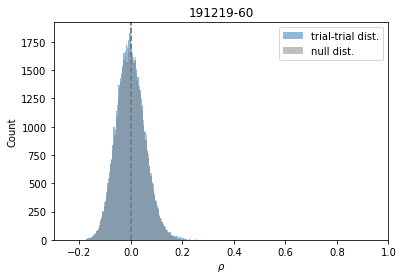

Session: 190604
Channel: 63


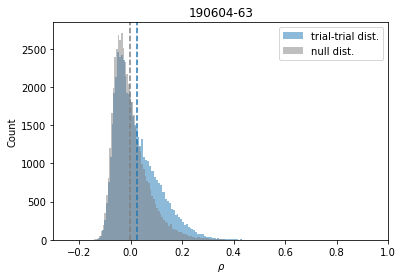

Session: 180627
Channel: 6


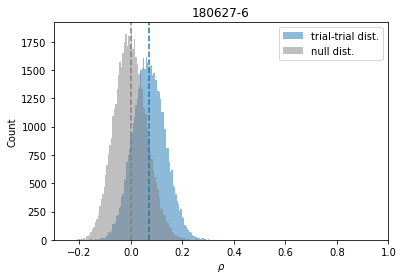

In [7]:
alpha = 0.5
bins = 100
save_tikz = False
for sess in selected_sess_ch.keys():
    print(f"Session: {sess}")
    channels = selected_sess_ch[sess]
    for ch in channels:
        print(f"Channel: {ch}")
        # plt.figure(figsize=(2, 2.5))
        plt.hist(session_norm_dist[sess][ch], color='tab:blue', alpha=alpha, bins=bins, label='trial-trial dist.')
        plt.hist(session_null_dist[sess][ch], color='gray', alpha=alpha, bins=bins, label='null dist.')
        plt.axvline(np.mean(session_norm_dist[sess][ch]), color='tab:blue', linestyle='--')
        plt.axvline(np.mean(session_null_dist[sess][ch]), color='gray', linestyle='--')

        plt.xlim(-0.3, 1.0)
        plt.title(f'{sess}-{ch}')
        plt.xlabel(f"$\\rho$")
        plt.ylabel('Count')
        plt.legend()
        if save_tikz:
            gap = sess_ch_gaps[f"{sess}-{ch}"]
            filepath = os.path.join(
                results_dir,
                'tikz_plots',
                f"norm-dist-gap-{gap}.tex"
                )
            PlotterUtils.save_tikz(filepath)
        plt.show()
        